# Methods for Approximating Schrödinger Bridge

Our use case requires computation of Schrödinger bridge (SB) with equal marginals. We use and compare two different methods for SB approximation. The first is the celebrated Sinkhorn algorithm [(Peyré, G. and Cuturi, M. (2019)., Section 4.2)](https://www.nowpublishers.com/article/Details/MAL-073) and the second is the the MCMC method from [Harchaoui et al. (2020)](https://projecteuclid.org/journals/bernoulli/volume-30/issue-3/Asymptotics-of-discrete-Schr%c3%b6dinger-bridges-via-chaos-decomposition/10.3150/23-BEJ1659.full).

In this notebook, we compute approximations to same marginal Schrödinger bridge using the two methods and compare their performance with increasing number of particles $n$ and decreasing regularization parameter $\epsilon$.

In [1]:
import numpy as np
import os
from scipy.special import expit
from scipy.stats import norm
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle as pkl
from estimate_SB import _gibbs_one_iter, schbridge, sinkhorn, cost_matrix
from matplotlib.animation import FuncAnimation
import seaborn as sns
import time

In [2]:
import matplotlib as mpl

mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['xtick.labelsize'] = 15
mpl.rcParams['ytick.labelsize'] = 15
mpl.rcParams["axes.labelsize"] = 15
mpl.rcParams['legend.fontsize'] = 15
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'

In [3]:
def cost_matrix(X, Y):
    """L2 cost matrix
    """
    n = X.shape[0]
    return (X.reshape((n,1)) - X.reshape((1,n)))**2

#### MCMC Approximation

The MCMC implementation utilizes `numba` for just-in-time compilation. Let us look at how using numba helps with saving compilation time.

In [4]:
n_list = 200*np.arange(1, 6) # number of iterations
gibbs_plan_list, cost_list, accept_ratio_list = [], [], []
eps = 0.01                   
mu, sigma_squared, sigma = 0, 1, 1
X_ = np.random.normal(mu, sigma, n_list[-1])
cost_mat = cost_matrix(X_, X_)

In [5]:
# Without JIT
start = time.perf_counter()
gibbs_cost, gibbs_plan, costs, accept = schbridge(cost_mat, eps=eps, total=1000, discard=0)
end = time.perf_counter()
print("Elapsed (with compilation) for {} samples = {}s".format(costs.shape[0], (end - start)))

# With JIT
start = time.perf_counter()
gibbs_cost, gibbs_plan, costs, accept = schbridge(cost_mat, eps=eps, total=1000, discard=0)
end = time.perf_counter()
print("Elapsed (after compilation) for {} samples = {}s".format(costs.shape[0], (end - start)))

Elapsed (with compilation) for 1000 samples = 2.860055861994624s
Elapsed (after compilation) for 1000 samples = 0.35159334493801s


Now we compute the MCMC approximation of the Schrödinger bridge with an increasing number of particles. As $n$ increases, the number of MCMC samples required for a valid approximation of the Schrödinger bridge becomes prohibitively large. We plot the heatmap of the computed Schrödinger bridge and the evolution of the Schrödinger cost with the number of iterations for different values of $n$. For the equal marginal case, the approximated Schrödinger bridge matrix should be approximately an identity matrix. 

In [ ]:
## THIS CODE TAKES >12 MINUTES TO RUN

for i in tqdm(range(len(n_list))):
    n = n_list[i]
    X = X_[:n]
    cost_mat = cost_matrix(X, X)
    gibbs_cost, gibbs_plan, all_costs, accept = schbridge(cost_mat, eps=eps, total=1000000, discard=10000)
    cumsum = np.cumsum(all_costs)
    cumavg = cumsum / np.arange(1, len(all_costs) + 1)
    gibbs_plan_list.append(gibbs_plan)
    cost_list.append(cumavg)
    accept_ratio_list.append(accept)

with open(f"mcmc/sample_size_increments/cost_list_eps{eps}.pkl", "wb") as input_file:
    pkl.dump(cost_list, input_file)
    
with open(f"mcmc/sample_size_increments/accept_ratio_list_eps{eps}.pkl", "wb") as input_file:
    pkl.dump(accept_ratio_list, input_file)
    
with open(f"mcmc/sample_size_increments/gibbs_plan_list_eps{eps}.pkl", "wb") as input_file:
    pkl.dump(gibbs_plan_list, input_file)

In [6]:
with open(f"mcmc/sample_size_increments/cost_list_eps{eps}.pkl", "rb") as input_file:
    cost_list = pkl.load(input_file)
    
with open(f"mcmc/sample_size_increments/accept_ratio_list_eps{eps}.pkl", "rb") as input_file:
    accept_ratio_list = pkl.load(input_file)
    
with open(f"mcmc/sample_size_increments/gibbs_plan_list_eps{eps}.pkl", "rb") as input_file:
    gibbs_plan_list = pkl.load(input_file)

[]

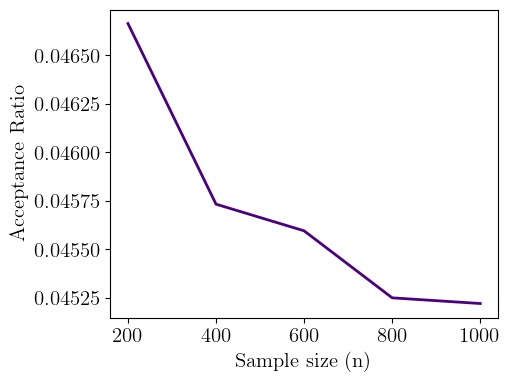

In [7]:
plt.figure(figsize=(5,4))
plt.plot(n_list, accept_ratio_list, color='indigo', linewidth=2)
plt.xlabel('Sample size (n)')
plt.ylabel('Acceptance Ratio')
plt.plot()

We observe that for $n=10^3$, even with $10^6$ MCMC steps, stationarity is not achieved.

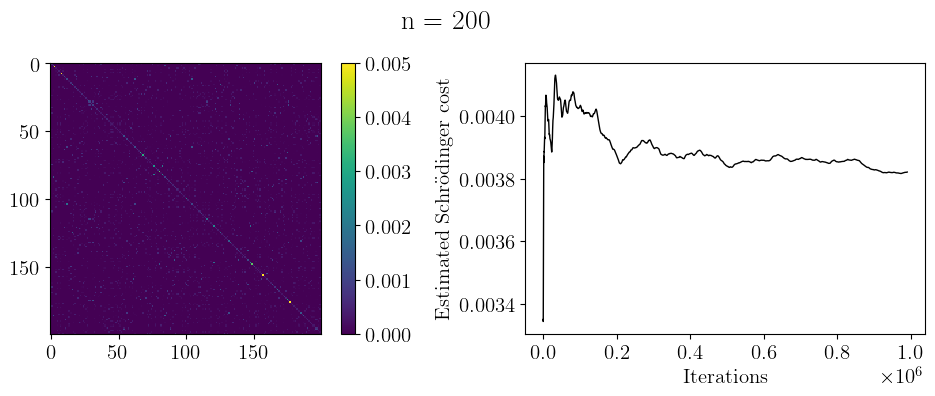

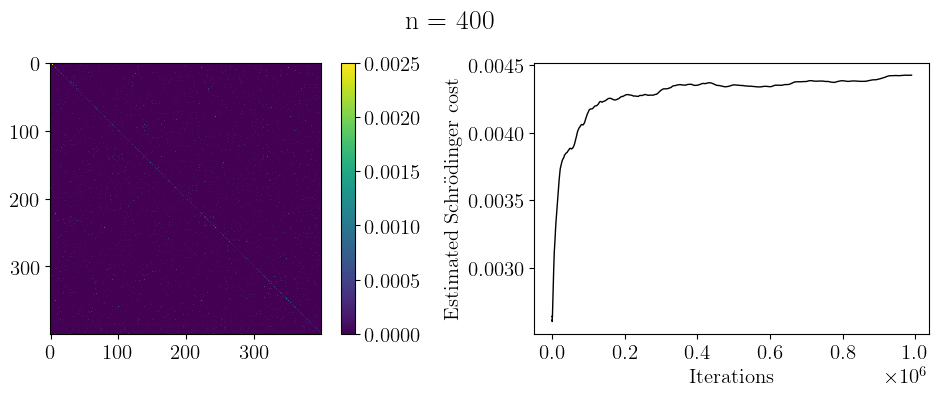

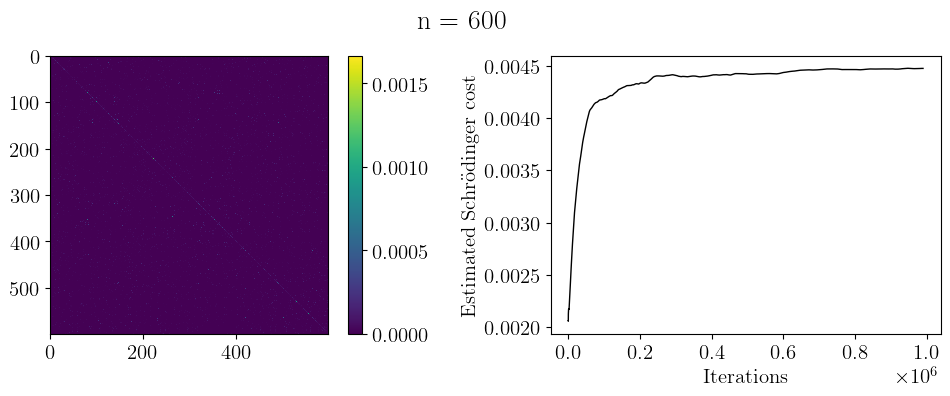

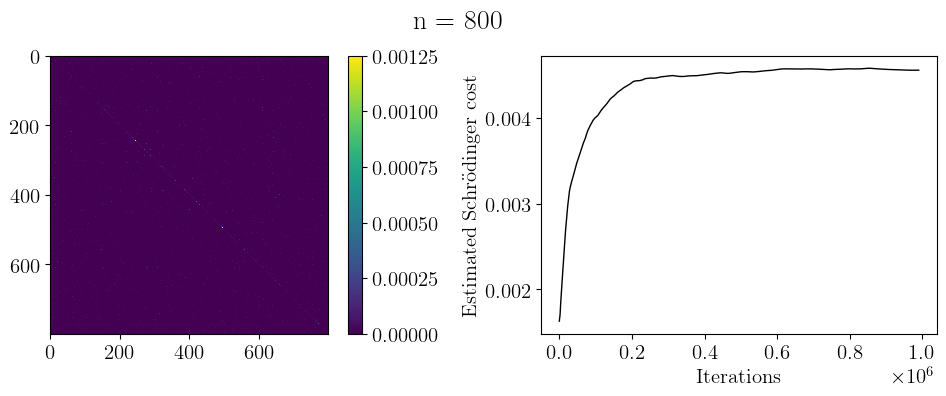

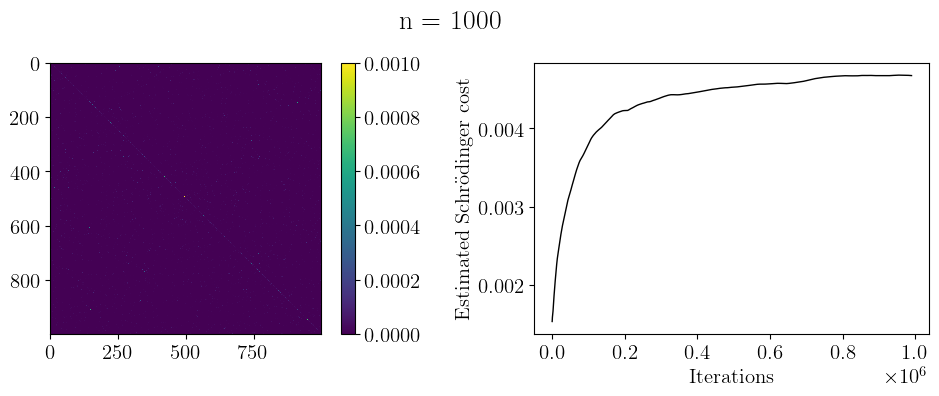

In [8]:
for i in range(len(n_list)):
    fig, axs = plt.subplots(1, 2, figsize=(10,4))
    axs[0].imshow(gibbs_plan_list[i], cmap='viridis', interpolation='nearest')
    axs[0].figure.colorbar(axs[0].images[0], ax=axs[0])
    # axs[0].set_title(f"Estimated Schrödinger Bridge, n = {n_list[i]}")
    axs[1].plot(np.arange(len(cost_list[i]))+1, cost_list[i], color='black')
    axs[1].set_xlabel('Iterations')
    axs[1].set_ylabel('Estimated Schrödinger cost')
    fig.suptitle(f'n = {n_list[i]}', fontsize=20)
    plt.tight_layout()
    plt.show()

Now we compare computation time, evolution of Schrödinger costs, and heatmap of estimated Schrödinger bridge by the two methods with $n=500$ particles. The MCMC methods runs Gibbs sampling for $10^6$ steps.

In [4]:
# Create Particles for forward process and calculate the cost matrix.
n = 500
eps = 0.001
mu, sigma_squared, sigma = 0, 4, 2
X = np.random.normal(mu, sigma, n)
cost_mat = cost_matrix(X, X)

In [5]:
# using MCMC method for estimating Schrödinger bridge
start = time.perf_counter()
gibbs_cost, gibbs_plan, gibbs_costs, accept = schbridge(cost_mat, eps=eps, total=1e6, discard=1e4)
end = time.perf_counter()
print("Gibbs time = {}s".format((end - start)))

# using Sinkhorn algorithm for estimating Schrödinger bridge
start = time.perf_counter()
sink_cost, sink_plan, sink_costs  = sinkhorn(cost_mat, np.ones(n)/n, np.ones(n)/n, eps, precision=1e-8, maxiter=1e4)
end = time.perf_counter()
print("Sinkhorn time = {}s".format((end - start)))

Gibbs time = 93.29903327999637s
Sinkhorn time = 28.331449036020786s


[]

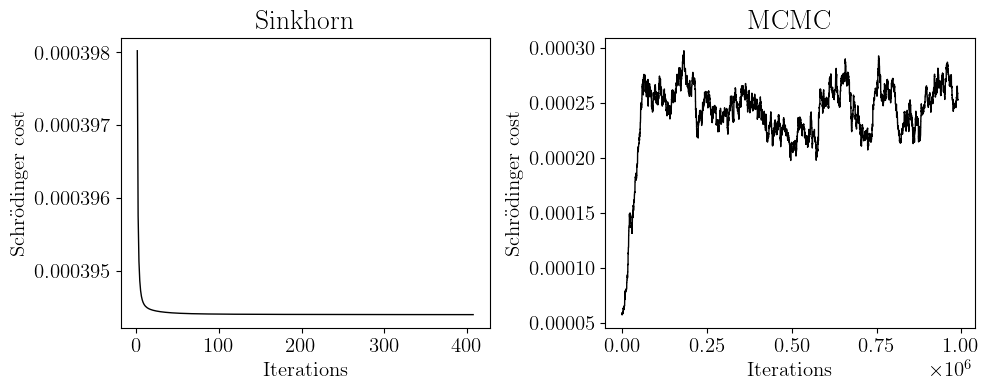

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))
axs[0].plot(np.arange(len(sink_costs))+1, sink_costs, color='black')
axs[0].set_xlabel('Iterations')
axs[0].set_ylabel('Schrödinger cost')
axs[0].set_title('Sinkhorn')

axs[1].plot(np.arange(len(gibbs_costs))+1, gibbs_costs, color='black')
axs[1].set_xlabel('Iterations')
axs[1].set_ylabel('Schrödinger cost')
axs[1].set_title('MCMC')

plt.tight_layout()
plt.plot()

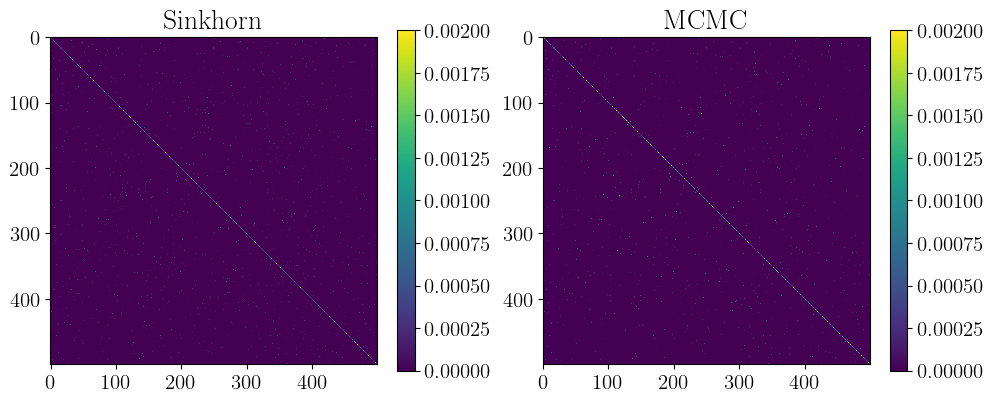

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))

# Create a heatmap
axs[0].imshow(sink_plan, cmap='viridis', interpolation='nearest')
axs[1].imshow(gibbs_plan, cmap='viridis', interpolation='nearest')
for ax in axs:
    ax.figure.colorbar(ax.images[0], ax=ax)

# Show the plot
axs[0].set_title('Sinkhorn')
axs[1].set_title('MCMC')

plt.tight_layout()
plt.show()